Entrenando modelos para técnica: Class Weight...
Entrenando modelos para técnica: SMOTE + Tomek...
Entrenando modelos para técnica: SMOTE + ENN...
Entrenando modelos para técnica: NearMiss...
Entrenando modelos para técnica: ADASYN...


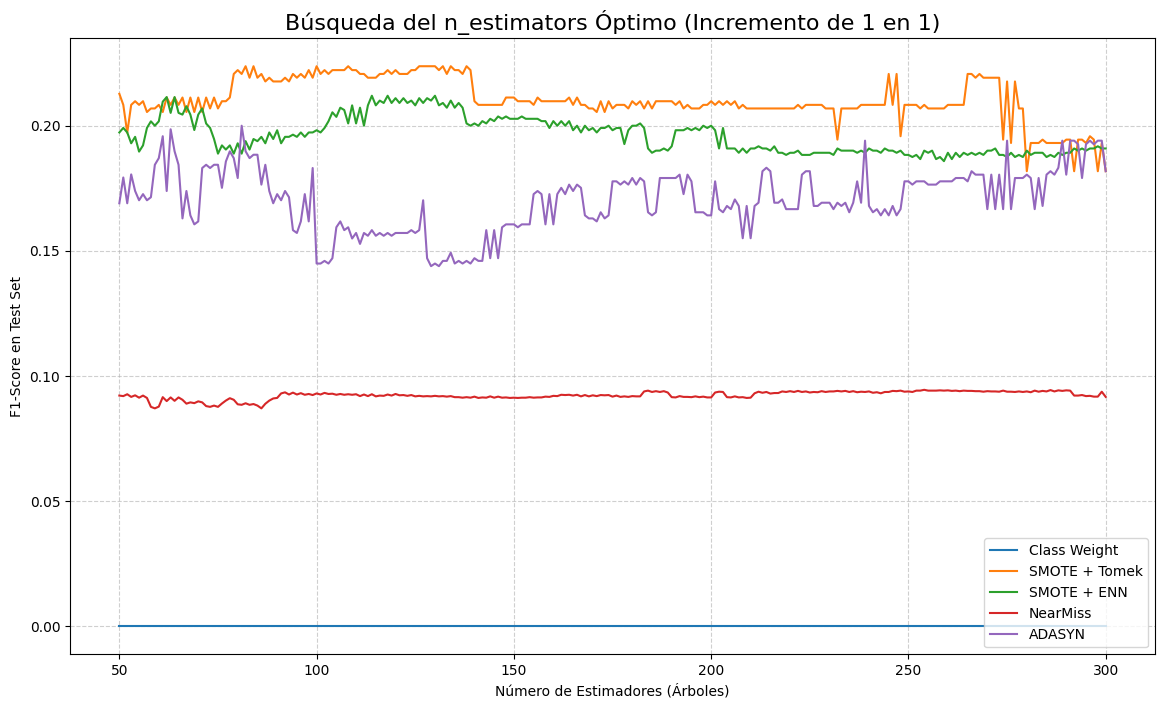


RESULTADOS DE OPTIMIZACIÓN POR TÉCNICA
🚀 Class Weight    | Óptimo: 50 árboles | F1: 0.0000
🚀 SMOTE + Tomek   | Óptimo: 82 árboles | F1: 0.2238
🚀 SMOTE + ENN     | Óptimo: 114 árboles | F1: 0.2120
🚀 NearMiss        | Óptimo: 254 árboles | F1: 0.0945
🚀 ADASYN          | Óptimo: 81 árboles | F1: 0.2000


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y Preparación de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

# Aplicar One-Hot Encoding a las variables categóricas
df_final = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# Separación de características y objetivo
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

# Split estratificado (mantenemos la proporción original en el test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Configuración del Experimento
# Rango de 50 a 300 de 1 en 1
n_estimators_range = range(50, 301) 
results = []

tecnicas = {
    'Class Weight': None,
    'SMOTE + Tomek': SMOTETomek(random_state=42),
    'SMOTE + ENN': SMOTEENN(random_state=42),
    'NearMiss': NearMiss(),
    'ADASYN': ADASYN(random_state=42)
}

plt.figure(figsize=(14, 8))

# 3. Loop de Entrenamiento
for nombre, sampler in tecnicas.items():
    f1_scores = []
    
    # Aplicar balanceo solo al set de entrenamiento
    if nombre == 'Class Weight':
        X_res, y_res = X_train, y_train
        cw = 'balanced'
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        cw = None
    
    print(f"Entrenando modelos para técnica: {nombre}...")
    
    for n in n_estimators_range:
        model = RandomForestClassifier(n_estimators=n, class_weight=cw, random_state=42, n_jobs=-1)
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
    
    # Graficar curva de aprendizaje
    plt.plot(n_estimators_range, f1_scores, label=nombre, linewidth=1.5)
    
    # Identificar el mejor punto
    mejor_f1 = max(f1_scores)
    mejor_n = list(n_estimators_range)[f1_scores.index(mejor_f1)]
    results.append({'Técnica': nombre, 'Mejor n_estimators': mejor_n, 'F1-Score': mejor_f1})

# Estética del gráfico
plt.title('Búsqueda del n_estimators Óptimo (Incremento de 1 en 1)', fontsize=16)
plt.xlabel('Número de Estimadores (Árboles)')
plt.ylabel('F1-Score en Test Set')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4. Resultados Detallados
print("\n" + "="*50)
print("RESULTADOS DE OPTIMIZACIÓN POR TÉCNICA")
print("="*50)
for r in results:
    print(f"🚀 {r['Técnica']:<15} | Óptimo: {r['Mejor n_estimators']} árboles | F1: {r['F1-Score']:.4f}")
print("="*50)

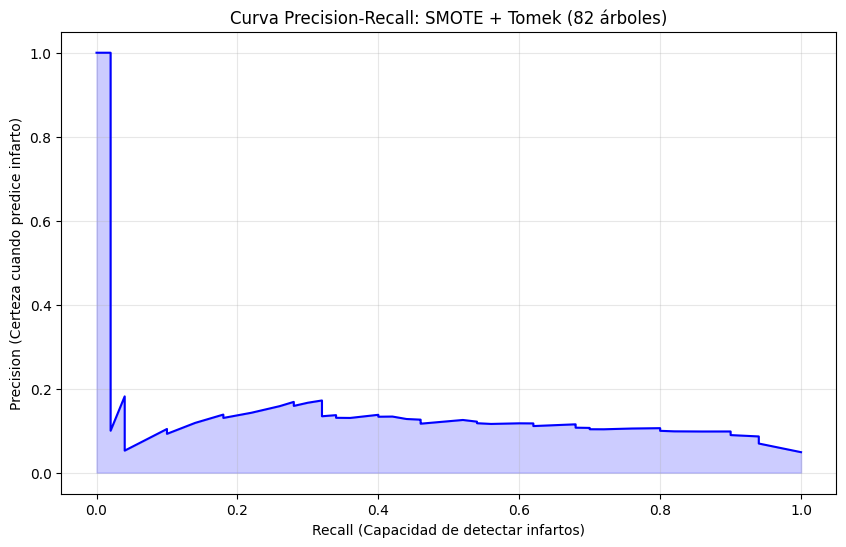

--- COMPARATIVA DE UMBRALES ---

UMBRAL: 0.5
Infartos detectados (Recall): 16 de 50
Falsas alarmas: 82
Recall: 32.00%

UMBRAL: 0.2
Infartos detectados (Recall): 34 de 50
Falsas alarmas: 267
Recall: 68.00%

UMBRAL: 0.1
Infartos detectados (Recall): 40 de 50
Falsas alarmas: 361
Recall: 80.00%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek

# 1. Preparación idéntica al notebook anterior
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Entrenamos el mejor modelo detectado
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

best_rf = RandomForestClassifier(n_estimators=82, random_state=42, n_jobs=-1)
best_rf.fit(X_res, y_res)

# 3. Obtener probabilidades (en lugar de clases directas)
# predict_proba nos da [prob_sano, prob_infarto]
probs = best_rf.predict_proba(X_test)[:, 1]

# 4. Calcular Precision-Recall para distintos umbrales
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Graficar Curva PR
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', label='Curva Precision-Recall')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall (Capacidad de detectar infartos)')
plt.ylabel('Precision (Certeza cuando predice infarto)')
plt.title('Curva Precision-Recall: SMOTE + Tomek (82 árboles)')
plt.grid(True, alpha=0.3)
plt.show()

# 5. EXPERIMENTO: Comparar Umbral 0.50 vs Umbral 0.20
print("--- COMPARATIVA DE UMBRALES ---")
for t in [0.5, 0.2, 0.1]:
    preds = (probs >= t).astype(int)
    cm = confusion_matrix(y_test, preds)
    # y_test tiene 50 infartos reales (aprox)
    infartos_detectados = cm[1,1] 
    falsas_alarmas = cm[0,1]
    
    print(f"\nUMBRAL: {t}")
    print(f"Infartos detectados (Recall): {infartos_detectados} de {y_test.sum()}")
    print(f"Falsas alarmas: {falsas_alarmas}")
    print(f"Recall: {infartos_detectados/y_test.sum():.2%}")